In [30]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, merge, AveragePooling3D, Dropout, Flatten, Activation
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from keras.laye

In [ ]:
rs.normalization import BatchNormalization
from keras.utils import np_utils
import tensorflow as tf
import os
import warnings
import keras.models as KM
from tensorflow.keras.losses import categorical_crossentropy

In [32]:
unpickled_df1 = pd.read_pickle("../input/5k-003/train_set_003.pkl")
unpickled_df2 = pd.read_pickle("../input/5k-003/valid_set_003.pkl")

X_train_df = unpickled_df1["subtom"][:]
Y_train_df = unpickled_df1["label"][:]
X_val_df=unpickled_df2["subtom"][:]
Y_val_df=unpickled_df2["label"][:]
print(X_train_df[0].shape)

(32, 32, 32)


In [33]:

#Xtrain Ytrain
l1=[]
for i in range(4000):
    l1.append(X_train_df[i])
X_train=np.array(l1)
X_train = X_train.reshape(X_train.shape[0], 32, 32, 32 , 1)
print(X_train.shape)
l2=[]
for i in range(4000):
    l2.append(Y_train_df[i])
y_train=np.array(l2)
classes=10
Y_train = np_utils.to_categorical(y_train, classes)#onehotencode
print(Y_train.shape)

#Xval,Yval
m1=[]
for i in range(1000):
    m1.append(X_val_df[i])
X_val=np.array(m1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 32 , 1)
print(X_val.shape)#4000x32x32x32x1
m2=[]
for i in range(1000):
    m2.append(Y_val_df[i])
y_val=np.array(m2)
classes=10
Y_val = np_utils.to_categorical(y_val, classes)#onehotencode
print(Y_val.shape)
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train)
X_val, Y_val = shuffle(X_val, Y_val)


(4000, 32, 32, 32, 1)
(4000, 10)
(1000, 32, 32, 32, 1)
(1000, 10)


In [34]:
tf.keras.regularizers.l2(l2=0.01)


In [54]:
#model

input_layer = Input((32, 32, 32, 1))
input = Input(shape = (32, 32, 32, 1), name='input')

m = Conv3D(32,(3, 3, 3), activation="relu", padding="same", name="conv1")(input)
m = BatchNormalization(name="bnorm1")(m)
# m = Dropout(0.1)(m)
m = Conv3D(32,(3, 3, 3), activation="relu", padding="same", name="conv2")(m)
m = BatchNormalization(name="bnorm11")(m)
m = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='maxpool1')(m)
# m = Dropout(0.1)(m)

m = Conv3D(64,(3, 3, 3), activation="relu", padding="same", name="conv3")(m)
m = BatchNormalization(name="bnorm2")(m)
# m = Dropout(0.1)(m)
m = Conv3D(64,(3, 3, 3), activation="relu", padding="same", name="conv4")(m)
m = BatchNormalization(name="bnorm21")(m)
m = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), name='maxpool2')(m)
# m = Dropout(0.1)(m)




m = Flatten(name='flatten')(m)
m = Dense(512, activation='relu', name='fc1',kernel_regularizer='l2')(m)
m = Dropout(0.4)(m)
m = Dense(512, activation='relu', name='fc2',kernel_regularizer='l2')(m)
m = Dropout(0.4)(m)
m = Dense(10, activation='linear', name='fc3')(m)
m = Activation('softmax', name='softmax')(m)

model = KM.Model(inputs=input, outputs=m)


In [55]:
model.summary()
# keras.utils.plot_model(model, "my_first_model.png",show_shapes=True)

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 32, 1)]   0         
_________________________________________________________________
conv1 (Conv3D)               (None, 32, 32, 32, 32)    896       
_________________________________________________________________
bnorm1 (BatchNormalization)  (None, 32, 32, 32, 32)    128       
_________________________________________________________________
conv2 (Conv3D)               (None, 32, 32, 32, 32)    27680     
_________________________________________________________________
bnorm11 (BatchNormalization) (None, 32, 32, 32, 32)    128       
_________________________________________________________________
maxpool1 (MaxPooling3D)      (None, 16, 16, 16, 32)    0         
_________________________________________________________________
conv3 (Conv3D)               (None, 16, 16, 16, 64)  

In [56]:
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_acc"]
        if val_acc >= self.threshold:
            self.model.stop_training = True
filepath = 'papercnn2_003.h5'
mcp = ModelCheckpoint(filepath,monitor='val_acc', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
my_callback = MyThresholdCallback(threshold=0.87)
earlystop = EarlyStopping(monitor='val_loss',mode='min',patience=10,verbose=1,)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5)

In [57]:
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['acc'])
history=model.fit(x=X_train, y=Y_train, batch_size=70, epochs=105, verbose=1,callbacks=[mcp, learning_rate_reduction, my_callback], validation_data=(X_val,Y_val),shuffle=False)


Epoch 1/105
57/58 [============================>.] - ETA: 0s - loss: 21.1844 - acc: 0.1368
Epoch 00001: val_acc improved from -inf to 0.10900, saving model to papercnn2_003.h5
58/58 [==============================] - 13s 230ms/step - loss: 21.1666 - acc: 0.1375 - val_loss: 19.3646 - val_acc: 0.1090
Epoch 2/105
57/58 [============================>.] - ETA: 0s - loss: 11.3738 - acc: 0.1441
Epoch 00002: val_acc improved from 0.10900 to 0.11800, saving model to papercnn2_003.h5
58/58 [==============================] - 13s 226ms/step - loss: 11.3679 - acc: 0.1447 - val_loss: 9.0468 - val_acc: 0.1180
Epoch 3/105
57/58 [============================>.] - ETA: 0s - loss: 7.7473 - acc: 0.1551
Epoch 00003: val_acc improved from 0.11800 to 0.13400, saving model to papercnn2_003.h5
58/58 [==============================] - 13s 226ms/step - loss: 7.7437 - acc: 0.1558 - val_loss: 6.6992 - val_acc: 0.1340
Epoch 4/105
57/58 [============================>.] - ETA: 0s - loss: 6.1475 - acc: 0.1401
Epoch 00

Epoch 30/105
57/58 [============================>.] - ETA: 0s - loss: 1.6332 - acc: 0.6338
Epoch 00030: val_acc improved from 0.50600 to 0.53500, saving model to papercnn2_003.h5
58/58 [==============================] - 13s 225ms/step - loss: 1.6328 - acc: 0.6338 - val_loss: 1.9990 - val_acc: 0.5350
Epoch 31/105
57/58 [============================>.] - ETA: 0s - loss: 1.5886 - acc: 0.6702
Epoch 00031: val_acc improved from 0.53500 to 0.65000, saving model to papercnn2_003.h5
58/58 [==============================] - 13s 225ms/step - loss: 1.5878 - acc: 0.6705 - val_loss: 1.6844 - val_acc: 0.6500
Epoch 32/105
57/58 [============================>.] - ETA: 0s - loss: 1.5812 - acc: 0.6875
Epoch 00032: val_acc improved from 0.65000 to 0.65900, saving model to papercnn2_003.h5
58/58 [==============================] - 13s 227ms/step - loss: 1.5810 - acc: 0.6873 - val_loss: 1.6414 - val_acc: 0.6590
Epoch 33/105
57/58 [============================>.] - ETA: 0s - loss: 1.5976 - acc: 0.6945
Epoch 

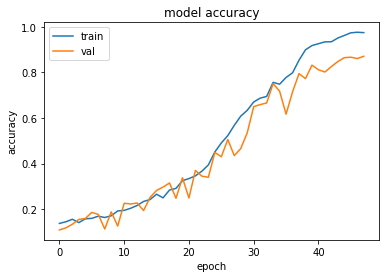

In [58]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

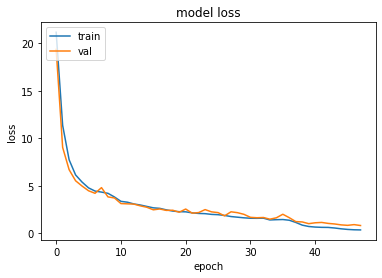

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
pred = model.predict(X_val)
pred = np.argmax(pred, axis=1)
pred

array([1, 7, 2, 4, 5, 6, 0, 0, 2, 8, 4, 7, 2, 6, 2, 8, 4, 0, 1, 0, 4, 8,
       6, 7, 9, 9, 1, 5, 9, 8, 9, 2, 4, 0, 0, 8, 0, 9, 5, 3, 7, 5, 9, 3,
       2, 6, 8, 1, 1, 9, 6, 7, 5, 0, 1, 5, 6, 3, 8, 1, 6, 7, 3, 1, 0, 3,
       8, 8, 7, 3, 7, 3, 2, 0, 3, 9, 1, 0, 2, 0, 1, 6, 3, 4, 5, 6, 7, 6,
       8, 9, 3, 8, 9, 8, 2, 4, 8, 6, 3, 5, 0, 6, 0, 4, 7, 4, 9, 7, 4, 8,
       5, 6, 3, 2, 0, 7, 0, 3, 8, 1, 8, 8, 6, 2, 7, 8, 5, 5, 3, 3, 4, 0,
       8, 5, 0, 2, 1, 2, 1, 5, 9, 4, 0, 5, 7, 2, 5, 1, 5, 2, 5, 3, 6, 0,
       8, 7, 6, 8, 8, 0, 7, 9, 5, 7, 3, 8, 7, 2, 0, 6, 7, 0, 8, 4, 8, 9,
       5, 2, 5, 8, 1, 2, 1, 2, 2, 2, 5, 2, 3, 0, 1, 4, 9, 3, 6, 5, 1, 3,
       5, 3, 6, 4, 4, 2, 8, 0, 8, 2, 2, 8, 8, 1, 3, 2, 6, 5, 3, 6, 2, 7,
       3, 2, 1, 9, 0, 5, 1, 6, 4, 4, 2, 2, 2, 7, 6, 1, 5, 4, 7, 9, 3, 4,
       0, 5, 4, 7, 3, 1, 8, 2, 7, 2, 1, 8, 1, 2, 6, 2, 2, 1, 9, 9, 2, 2,
       9, 8, 4, 0, 0, 2, 9, 0, 0, 6, 4, 3, 9, 9, 3, 3, 7, 9, 5, 9, 1, 1,
       4, 9, 9, 1, 0, 9, 9, 2, 0, 9, 2, 7, 9, 9, 1,

In [61]:
print("Evaluate on test data")
results = model.evaluate(X_val, Y_val)
print("test loss, test acc:", results)

Evaluate on test data
32/32 [==============================] - 1s 31ms/step - loss: 0.8226 - acc: 0.8710
test loss, test acc: [0.8225597739219666, 0.8709999918937683]


In [66]:
model.save('papercnn2_003.h5')

In [67]:
from tensorflow.keras.models import load_model
model1 = load_model('papercnn2_003.h5')

In [68]:
print("Evaluate on test data")
results = model1.evaluate(X_val, Y_val)
print("test loss, test acc:", results)

Evaluate on test data
32/32 [==============================] - 1s 32ms/step - loss: 0.8226 - acc: 0.8710
test loss, test acc: [0.8225597739219666, 0.8709999918937683]
